# Neutron Event Analyzer Tutorial

This tutorial demonstrates how to use the `neutron_event_analyzer` package to process and analyze neutron event camera data. The package processes `.empirphot` and `.empirevent` files, associates photons with events, computes ellipticity, and generates diagnostic plots. It supports two association methods: a simple method and an optional `lumacamTesting`-based method (if installed).

## Setup

Ensure you have installed the package:

```bash
pip install neutron_event_analyzer
```

For the `lumacamTesting` association method, install the optional dependency:

```bash
pip install neutron_event_analyzer[lumacam]
```

You need a data folder with the following structure:

```
data_folder/
├── photonFiles/
│   └── *.empirphot
└── eventFiles/
    └── *.empirevent
```

Additionally, provide the path to the `export` directory containing the `empir_export_events` and `empir_export_photons` binaries.

## Prerequisites

Let's import the necessary module and set up the environment.

In [1]:
import neutron_event_analyzer as nea
import numpy as np

# Define paths (replace with your actual paths)
data_folder = '/home/ni_user/analysis/data/02_nanoguide_front_openbeam_00000'
export_dir = '/home/ni_user/analysis/export'

## Step 1: Initialize the Analyser

Create an `Analyse` object, specifying the data folder, export directory, and whether to use `lumacamTesting` (if available).

In [2]:
# Initialize with simple association
analyser = nea.Analyse(data_folder=data_folder, export_dir=export_dir)
print("Analyser initialized.")

Analyser initialized.


## Step 2: Load Event and Photon Data

Load the event and photon files into DataFrames. You can specify custom glob patterns if needed.

In [7]:
# Load events
analyser.load(event_glob="/home/ni_user/analysis/data/02_nanoguide_front_openbeam_00000/eventFiles/2025-08-19T122525_00000[1-5].empirevent",
             photon_glob="/home/ni_user/analysis/data/02_nanoguide_front_openbeam_00000/photonFiles/2025-08-19T122525_00000[1-5].empirphot")

Found 5 paired files.


Loading pairs:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded 4721 events and 2179598 photons in total.


## Step 3: Associate Photons to Events

Associate photons to events using either the simple method or the `lumacamTesting` method.

In [8]:
# Association
analyser.associate(time_norm_ns=1, spatial_norm_px=5, dSpace_px=50, verbosity=1)

Associating pairs:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Matched 9462 of 2179598 photons (0.4%)


In [13]:
analyser.associated_df.dropna()

,x,y,t,tof,assoc_event_id,assoc_x,assoc_y,assoc_t,assoc_n,assoc_PSD,time_diff_ns,spatial_diff_px
367,65.62,70.62,2.018872,5.046875e-07,1039.0,66.53,69.81,2.018872,2.0,1.171875e-08,0.000000,1.218277
368,51.42,46.00,2.018872,5.125000e-07,1039.0,66.53,69.81,2.018872,2.0,1.171875e-08,7.813000,28.199791
566,24.56,62.54,2.018884,4.828125e-07,298.0,25.41,62.14,2.018884,2.0,3.906250e-09,0.000000,0.939415
567,50.39,50.00,2.018884,4.828125e-07,298.0,25.41,62.14,2.018884,2.0,3.906250e-09,0.000000,27.773729
1251,145.31,72.83,2.018915,7.187500e-07,2642.0,146.16,72.18,2.018915,2.0,3.125000e-09,0.000000,1.070047
...,...,...,...,...,...,...,...,...,...,...,...,...
434232,44.45,64.26,9.968765,3.218750e-07,701.0,48.50,75.23,9.968765,2.0,3.125001e-09,3.124999,11.693733
435154,149.20,108.44,9.968832,4.781250e-07,2586.0,143.30,97.73,9.968832,2.0,2.265625e-08,0.000000,12.227596
435156,142.61,96.74,9.968832,4.781250e-07,2586.0,143.30,97.73,9.968832,2.0,2.265625e-08,0.000000,1.206731
435322,47.56,14.00,9.968836,4.171875e-07,851.0,56.13,11.15,9.968836,2.0,3.906250e-09,1.563000,9.031467


## Step 4: Compute Ellipticity

Compute ellipticity and related metrics for multi-photon events. Use the appropriate event column for lumacam (`assoc_cluster_id`).

In [14]:
analyser.compute_ellipticity(verbosity=1)

🧮 Computing ellipticity:   0%|          | 0/4704 [00:00<?, ?it/s]

✅ Computed shape for 4704 events.


## Step 5: Retrieve Combined DataFrame

Get the DataFrame containing associated photon and event data, including ellipticity metrics.

In [15]:
combined_df = analyser.get_combined_dataframe()
combined_df.dropna().head()


,x,y,t,tof,assoc_event_id,assoc_x,assoc_y,assoc_t,assoc_n,assoc_PSD,time_diff_ns,spatial_diff_px,major_x,major_y,angle_deg,ellipticity
1251,145.31,72.83,2.018915,7.187500e-07,2642.0,146.16,72.18,2.018915,2.0,3.125000e-09,0.000,1.070047,-0.790358,0.612645,142.219021,9.855360e-09
1252,147.00,71.52,2.018915,7.250000e-07,2642.0,146.16,72.18,2.018915,2.0,3.125000e-09,6.250,1.068270,-0.790358,0.612645,142.219021,9.855360e-09
1369,15.76,95.59,2.018918,3.843750e-07,155.0,14.24,98.85,2.018918,2.0,4.687500e-09,1.563,3.596943,-0.191510,0.981491,101.040940,2.522362e-09
1370,14.96,99.69,2.018918,3.859375e-07,155.0,14.24,98.85,2.018918,2.0,4.687500e-09,0.000,1.106345,-0.191510,0.981491,101.040940,2.522362e-09
2208,216.29,108.71,2.018961,4.093750e-07,4127.0,217.15,108.14,2.018961,2.0,7.812502e-10,0.000,1.031746,-0.829804,0.558055,146.078591,0.000000e+00


## Step 6: Generate Diagnostic Plots

Create four diagnostic plots to visualize event data.

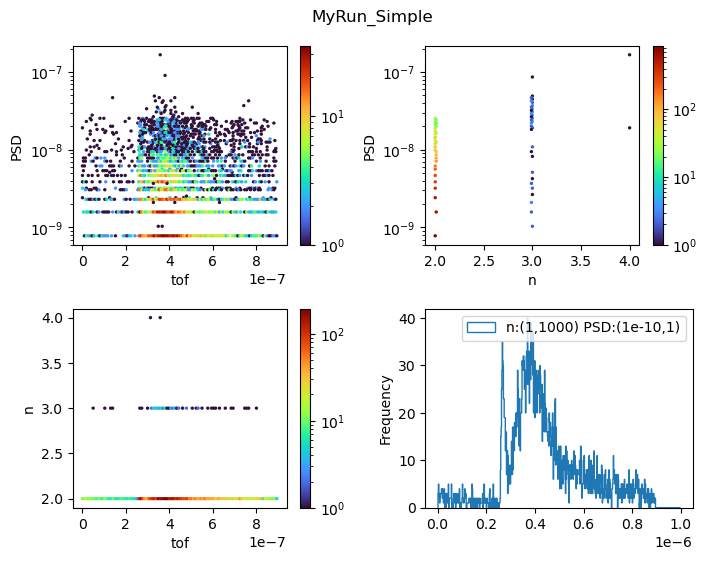

In [16]:
analyser.plot_four(name='MyRun_Simple', min_n=1, max_n=1000, min_psd=1e-10, max_psd=1)

## Step 7: Plot a Specific Event

Visualize a specific event to see its associated photons and event center.

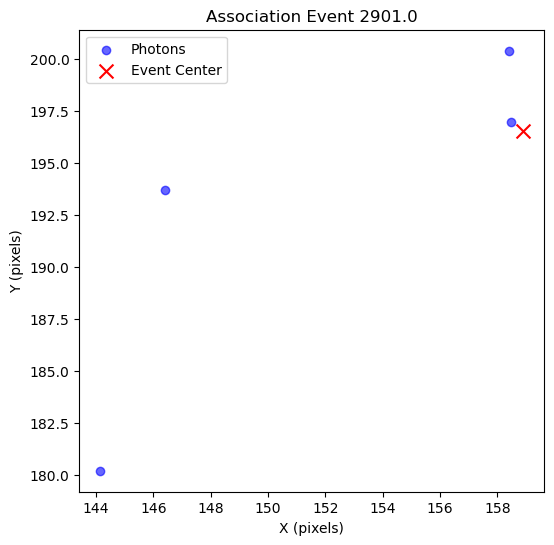

In [25]:
# Plot an event from the association
event_id = combined_df.query("assoc_n>3")['assoc_event_id'].dropna().iloc[0]  # First non-NaN event ID
analyser.plot_event(event_id=event_id, title=f'Association Event {event_id}')


## Notes

- Ensure the `export_dir` contains the required binaries.
- The `lumacamTesting` method requires the optional dependency and uses `assoc_cluster_id` instead of `assoc_event_id`.
- Adjust `n_threads` based on your system's capabilities.
- The `plot_four` method generates hexbin plots and a histogram for event analysis.
- The `plot_event` method visualizes individual events with their photons and event center.
- For large datasets, processing may take time; monitor progress via the `tqdm` bars.

For more details, refer to the [README](README.md) file in the package directory.

# Optional: associate using `lumacamTesting`


In [ ]:
# Initialize with lumacamTesting (if installed)
analyser_lumacam = Analyse(data_folder=data_folder, export_dir=export_dir, n_threads=4, use_lumacam=True)
print("Lumacam analyser initialized.")

In [ ]:
analyser_lumacam.load_photons()
analyser_lumacam.load_events()

In [ ]:
# Lumacam association (if lumacamTesting is installed)
analyser_lumacam.associate(weight_px_in_s=None, max_dist_s=None, verbosity=1)